In [1]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time
import simulation_functions as sfs

np.random.seed(42)

import importlib
importlib.reload(sfs)

<module 'simulation_functions' from '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/simulation_functions.py'>

In [2]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/'
f = h5py.File(path_to_filtered_data+'filtered_jmpool_ex5_kin.h5','r')
lengths = np.array(f['MetaData/lengths_data'],dtype=int)
bouttypes= ma.array(f['bout_types'], dtype=int)
# stims = ma.array(f['stims'])
# ecs = ma.array(f['eye_convergence'])

##shapes are n_fish, max_n_bouts,dim of variable

bouttypes_allcond= ma.array(f['bout_types'])
stims_allcond = ma.array(f['stims'])
ecs_allcond = ma.array(f['eye_convergence'])
time_Bout_allcond = ma.array(f['times_bouts']) #raw times bouts

#shapes are n_fish, max_n_bouts,dim of variable
X_head_allcond = ma.array(f['head_pos'])
phi_smooth_allcond = ma.array(f['orientation_smooth'])
speeds_head_allcond = ma.array(f['speed_head'])
f.close()

In [3]:
time_Bout_allcond[time_Bout_allcond == 0] = ma.masked
X_head_allcond[X_head_allcond == 0] = ma.masked
phi_smooth_allcond[phi_smooth_allcond == 0] = ma.masked
speeds_head_allcond[phi_smooth_allcond.mask] = ma.masked
bouttypes_allcond[bouttypes_allcond == 15] = ma.masked
ecs_allcond[ecs_allcond == 100] = ma.masked

In [4]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','ChasingDot coarsespeeds(5x5cm)','ChasingDot finespeeds(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[515,525],[160,172],[87,148],[43,60],[22,43],[60,87],
                           [202,232],[148,160],[172,202],[505,515],[0,22],
                           [232,301],[347,445],[301,316],[316,347],
                           [445,505]])

In [5]:
conditions = np.zeros((np.max(condition_recs),2),dtype='object')
for k in range(len(condition_recs)):
    t0,tf = condition_recs[k]
    conditions[t0:tf,0] = np.arange(t0,tf)
    conditions[t0:tf,1] = [condition_labels[k] for t in range(t0,tf)]

In [6]:
recs_remove = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/recs_remove.npy')

In [7]:
recs_remove = np.hstack([recs_remove, np.arange(22,60)])

In [8]:
conditions = np.delete(conditions, recs_remove, axis=0)

In [9]:
print(recs_remove)

[ 90 260 264 270 276 352 358 364 375 381 383 392 398 404 410 416 422 427
 433 439 450 456 467 497  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59]


In [10]:
X_head_allcond = np.delete(X_head_allcond, recs_remove, axis=0)
X_head_allcond[X_head_allcond == 0] = ma.masked

time_Bout_allcond = np.delete(time_Bout_allcond,recs_remove, axis=0)
time_Bout_allcond[time_Bout_allcond == 0] = ma.masked

phi_smooth_allcond = np.delete(phi_smooth_allcond, recs_remove, axis=0)
phi_smooth_allcond[phi_smooth_allcond == 0] = ma.masked
speeds_head_allcond = np.delete(speeds_head_allcond, recs_remove,axis=0)
speeds_head_allcond[phi_smooth_allcond.mask] = ma.masked

stims_allcond = np.delete(stims_allcond, recs_remove, axis=0)
stims_allcond[stims_allcond == 100] = ma.masked

ecs_allcond = np.delete(ecs_allcond, recs_remove, axis=0)
ecs_allcond[ecs_allcond == 100] = ma.masked

In [11]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data + 'kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish_allrec = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()

# lengths_all = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/lengths_ex2_recordings.npy')
# lengths_all = lengths

In [12]:
# recs_ = np.asarray(conditions[:,0], dtype=int)

to_mask = 1300

# maxL = np.max(lengths_all[recs_])
maxL = np.max(lengths_all)

labels_fish_allrec[labels_fish_allrec == to_mask] = ma.masked

# labels_fishrec = to_mask * ma.ones((len(recs_), maxL))
# labels_fishrec = labels_fish_allrec[recs_,:maxL+2]
# labels_fishrec = np.delete(labels_fishrec,4,0)

# labels_fishrec[labels_fishrec == to_mask] = ma.masked
labels_fish = labels_fish_allrec

# lengths_rem = np.delete(lengths_all, recs_remove)
lengths_rem = lengths_all

In [13]:
## Select Dataset
np.random.seed(42)
seeds = np.random.randint(0,10000,100)
delay_range = np.arange(1,20,1)
dt = 1
div= 463
n_modes=50
labels_all= ma.concatenate(labels_fish,axis=0)
print(labels_fish.shape)

(463, 11651)


In [14]:
P_ensemble = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/P_ensemble_ex8_N1200_s8684.npy')

In [15]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

In [16]:
import msmtools.estimation as msm_estimation
delay = 3
dt = 1
print(delay)
# lcs_ensemble,P_ensemble = op_calc.transition_matrix(labels_all,delay,return_connected=True)
lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
inv_measure = op_calc.stationary_distribution(P_ensemble)
final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)
R = op_calc.get_reversible_transition_matrix(P_ensemble)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=123)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

3


In [17]:
split_locs = []
distorted_eigfs = np.zeros((eigfunctions.shape[0], eigfunctions.shape[1]-1))
for i in range(1,eigfunctions.shape[1]):
    phi = eigfunctions[:,i]
    _,_,_,split_idx,_ = op_calc.optimal_partition(phi,inv_measure,P_ensemble,return_rho=True)

    sort_range = np.sort(phi)
    neg_range = np.linspace(-1,0, len(sort_range[0:split_idx]))
    pos_range = np.linspace(0,1,len(sort_range[split_idx:]))
    distort_r = np.hstack([neg_range,pos_range])
    distort = np.zeros(phi.shape)

    pos = [np.where(phi == a)[0][0] for a in np.sort(phi)]

    for j in range(phi.shape[0]):
        distort[pos[j]] = distort_r[j]

    distorted_eigfs[:,i-1] = distort
    split_locs.append(split_idx)

In [18]:
distorted_trajs = ma.array(distorted_eigfs)[final_labels,:]
distorted_trajs[final_labels.mask] = ma.masked

distorted_fish = distorted_trajs.reshape(labels_fish.shape[0], labels_fish.shape[1], -1)

dtrajs_fish_phi1 = distorted_fish[:,:,0]
dtrajs_fish_phi2 = distorted_fish[:,:,1]

In [19]:
kms = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/pool_ex8_PCs/cg2_labels.npy')
kmeans_labels = kms
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask

## Prey Capture hunting rates

In [383]:
cond = 15

pc_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
print(pc_recs)

maxL = np.max(lengths_rem[pc_recs])
lengths = lengths_rem[pc_recs]

[387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442]


In [384]:
time_Bout = time_Bout_allcond[pc_recs,:maxL,:]
ecs_pc = ecs_allcond[pc_recs,:maxL]

In [385]:
print(time_Bout.shape)
print(ecs_pc.shape)

(56, 2305, 2)
(56, 2305)


In [386]:
tmspace_clusters = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/spectral_split_g7.npy')[pc_recs]

In [387]:
print(np.unique(tmspace_clusters))

[0 5 6]


In [388]:
posterior = np.load('/Users/gautam.sridhar/Documents/ZENITH/Figures/posterior_f.npy')[pc_recs]
post_f = posterior/posterior.sum(axis=0)

0.02198577359546758 0.23556194441603617 0.2749514377872319
0.04506281507388 0.23556194441603617 0.2749514377872319
0.08664622634511077 0.23556194441603617 0.2749514377872319


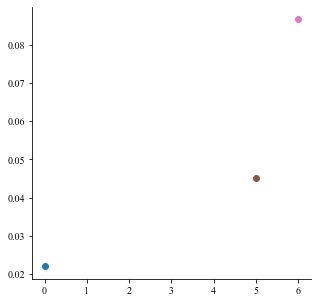

In [391]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

m_pc = []
cil_pc = []
ciu_pc = []

for clus in [0,5,6]:
    hunt_num = 0.0
    for  cf in range(len(pc_recs)):
        if ((time_Bout[cf,lengths[cf]-1,1] - time_Bout[cf,0,0])/700/60) > 5:
            hunt_num += post_f[cf,clus]*(len(np.where(ecs_pc[cf] == 2)[0])/lengths[cf])
    
    print(hunt_num, cil,ciu)
    ax.scatter(clus, hunt_num,c='C{}'.format(clus))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

0
0.022085736133775895 0.020125141615169744 0.026077285855409225
5
0.04545856002100253 0.036630239388399606 0.058229253820704055
6
0.086780147181933 0.0679633529695132 0.10671522908558707


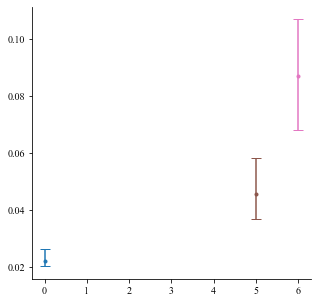

In [394]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

m_pc = []
cil_pc = []
ciu_pc = []

for clus in [0,5,6]:
    print(clus)
    hunt_rats = []
    for i in range(100):
        hunt_num = []
        recs_ = np.random.choice(np.arange(len(pc_recs)),len(pc_recs),replace=True, p=post_f[:,clus])
        for cf in recs_:
            if ((time_Bout[cf,lengths[cf]-1,1] - time_Bout[cf,0,0])/700/60) > 5:
                hunt_num.append(len(np.where(ecs_pc[cf] == 2)[0])/lengths[cf])
        hunt_rats.append(np.mean(hunt_num))
    m = np.mean(hunt_rats)
    cil = np.nanpercentile(hunt_rats, 2.5)
    ciu = np.nanpercentile(hunt_rats, 97.5)
    ax.errorbar(clus, m, np.asarray([np.asarray(m-cil), np.asarray(ciu-m)])[:,np.newaxis],fmt='.', capsize=5, color='C{}'.format(clus))
    m_pc.append(m)
    cil_pc.append(cil)
    ciu_pc.append(ciu)
    
    print(m, cil,ciu)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylim(0,8.5)
# ax.set_xlabel('Clusters',fontsize=35)
# ax.set_ylabel('EC events/min',fontsize=35)
# plt.yticks(fontsize=30)
# plt.xticks(rotation=70)
# fig.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig6/LRW_ec_perc_ha.pdf')